In [1]:
import zipfile
import requests
import cv2
import matplotlib.pyplot as plt
import glob
import random
import os

## Install Ultralytics Package

In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling

## Download the Dataset

In [3]:
os.makedirs('datasets', exist_ok=True)

In [4]:
%cd datasets

/content/datasets


In [5]:
def download_file(url, save_name):
    url = url
    if not os.path.exists(save_name):
        file = requests.get(url)
        open(save_name, 'wb').write(file.content)

download_file(
    'https://www.dropbox.com/s/qvglw8pqo16769f/pothole_dataset_v8.zip?dl=1',
    'pothole_dataset_v8.zip'
)

In [6]:
# Unzip the data file
def unzip(zip_file=None):
    try:
        with zipfile.ZipFile(zip_file) as z:
            z.extractall("./")
            print("Extracted all")
    except:
        print("Invalid file")

unzip('pothole_dataset_v8.zip')

Extracted all


In [7]:
%cd ..

/content


## Visualize Images from the Dataset

In [8]:
# Function to convert bounding boxes in YOLO format to xmin, ymin, xmax, ymax.
def yolo2bbox(bboxes):
    xmin, ymin = bboxes[0]-bboxes[2]/2, bboxes[1]-bboxes[3]/2
    xmax, ymax = bboxes[0]+bboxes[2]/2, bboxes[1]+bboxes[3]/2
    return xmin, ymin, xmax, ymax

In [9]:
def plot_box(image, bboxes, labels):
    # Need the image height and width to denormalize
    # the bounding box coordinates
    h, w, _ = image.shape
    for box_num, box in enumerate(bboxes):
        x1, y1, x2, y2 = yolo2bbox(box)
        # Denormalize the coordinates.
        xmin = int(x1*w)
        ymin = int(y1*h)
        xmax = int(x2*w)
        ymax = int(y2*h)

        thickness = max(2, int(w/275))

        cv2.rectangle(
            image,
            (xmin, ymin), (xmax, ymax),
            color=(0, 0, 255),
            thickness=thickness
        )
    return image

In [10]:
# Function to plot images with the bounding boxes.
def plot(image_paths, label_paths, num_samples):
    all_images = []
    all_images.extend(glob.glob(image_paths+'/*.jpg'))
    all_images.extend(glob.glob(image_paths+'/*.JPG'))

    all_images.sort()

    num_images = len(all_images)

    plt.figure(figsize=(15, 12))
    for i in range(num_samples):
        j = random.randint(0,num_images-1)
        image_name = all_images[j]
        image_name = '.'.join(image_name.split(os.path.sep)[-1].split('.')[:-1])
        image = cv2.imread(all_images[j])
        with open(os.path.join(label_paths, image_name+'.txt'), 'r') as f:
            bboxes = []
            labels = []
            label_lines = f.readlines()
            for label_line in label_lines:
                label = label_line[0]
                bbox_string = label_line[2:]
                x_c, y_c, w, h = bbox_string.split(' ')
                x_c = float(x_c)
                y_c = float(y_c)
                w = float(w)
                h = float(h)
                bboxes.append([x_c, y_c, w, h])
                labels.append(label)
        result_image = plot_box(image, bboxes, labels)
        plt.subplot(2, 2, i+1)
        plt.imshow(result_image[:, :, ::-1])
        plt.axis('off')
    plt.subplots_adjust(wspace=1)
    plt.tight_layout()
    plt.show()

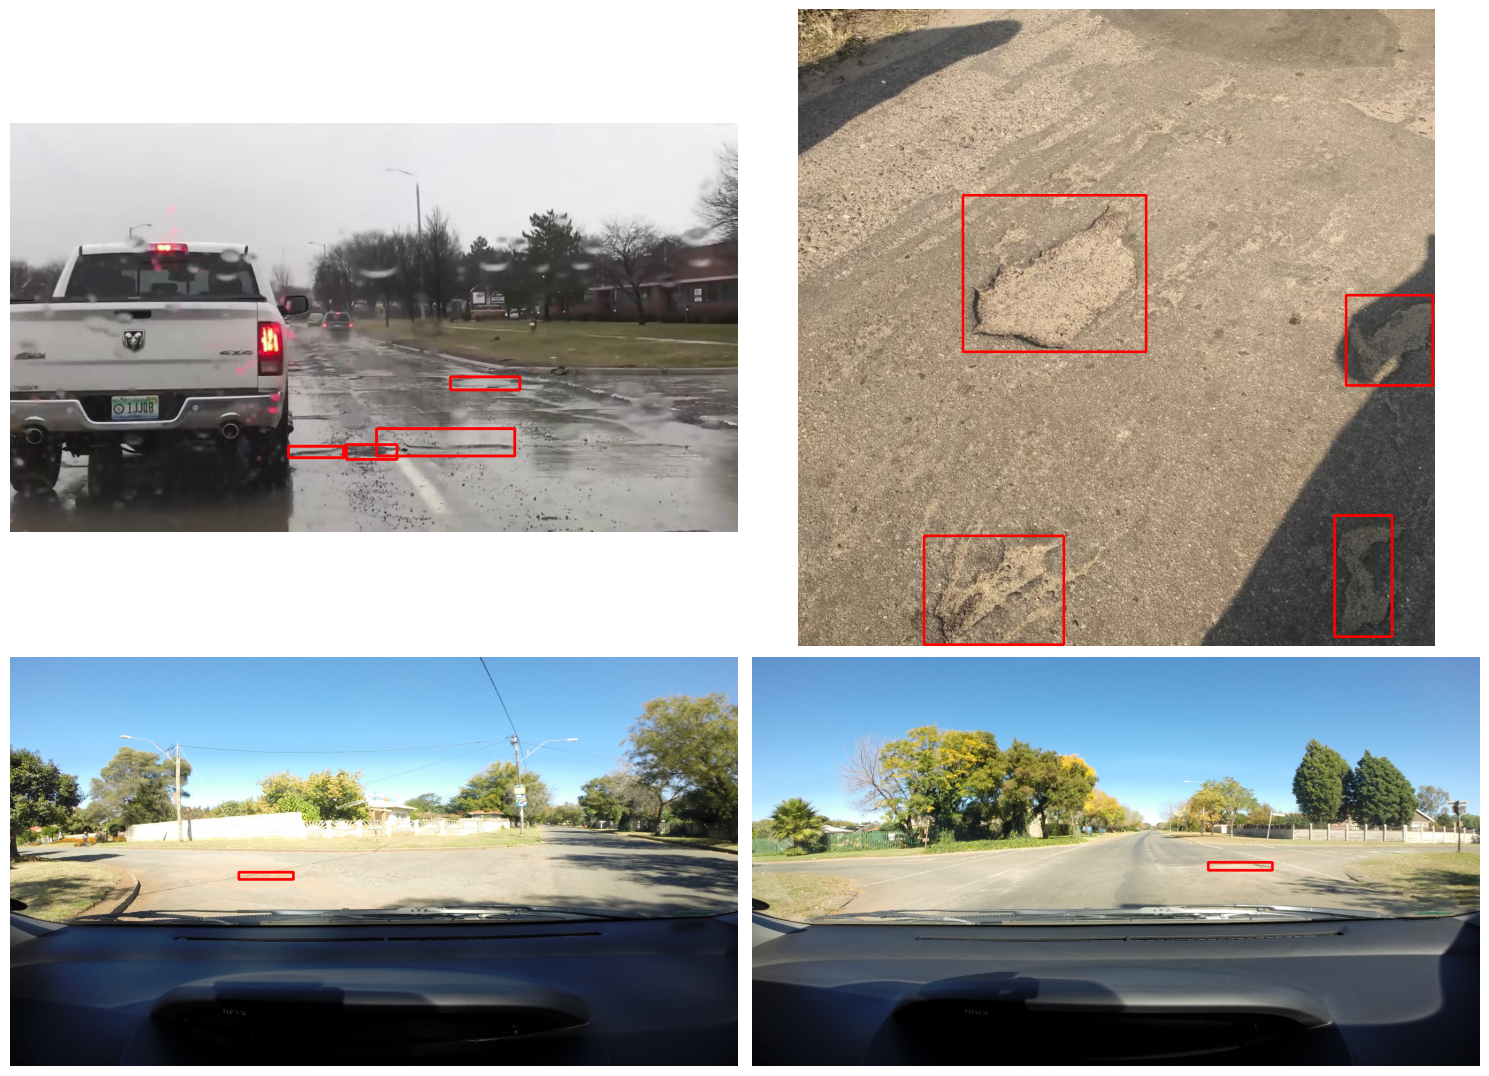

In [11]:
# Visualize a few training images.
plot(
    image_paths='datasets/pothole_dataset_v8/train/images/',
    label_paths='datasets/pothole_dataset_v8/train/labels/',
    num_samples=4,
)

In [12]:
def dataset_summary(image_dir, label_dir):
    image_files = glob.glob(os.path.join(image_dir, '*.jpg'))
    label_files = glob.glob(os.path.join(label_dir, '*.txt'))
    print(f"Jumlah gambar: {len(image_files)}")
    print(f"Jumlah file label: {len(label_files)}")

    total_objects = 0
    class_counts = {}

    for label_path in label_files:
        with open(label_path, 'r') as f:
            for line in f:
                class_id = line.split()[0]
                total_objects += 1
                class_counts[class_id] = class_counts.get(class_id, 0) + 1

    print(f"Total objek teranotasi: {total_objects}")
    print("Distribusi kelas:")
    for cls, count in class_counts.items():
        print(f"  Class {cls}: {count} objek")

# Panggil untuk train dan valid
print("== Dataset Train ==")
dataset_summary('datasets/pothole_dataset_v8/train/images', 'datasets/pothole_dataset_v8/train/labels')

print("\n== Dataset Valid ==")
dataset_summary('datasets/pothole_dataset_v8/valid/images', 'datasets/pothole_dataset_v8/valid/labels')


== Dataset Train ==
Jumlah gambar: 6962
Jumlah file label: 6960
Total objek teranotasi: 15145
Distribusi kelas:
  Class 0: 15145 objek

== Dataset Valid ==
Jumlah gambar: 271
Jumlah file label: 271
Total objek teranotasi: 753
Distribusi kelas:
  Class 0: 753 objek


## Dataset YAML File

In [13]:
%%writefile pothole_v8.yaml
path: 'pothole_dataset_v8/'
train: 'train/images'
val: 'valid/images'

# class names
names:
  0: 'pothole'

Writing pothole_v8.yaml


## YOLOv8 Nano Training

In [14]:
# Sample training for 5 epoch.
EPOCHS = 5
!yolo task=detect mode=train model=yolov8n.pt imgsz=1280 data=pothole_v8.yaml epochs={EPOCHS} batch=8 name=yolov8n_v8_50e

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.
100% 6.25M/6.25M [00:00<00:00, 107MB/s]
Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=8, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=pothole_v8.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=5, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=1280, int8=False, iou=0

## Evaluation on Validation Images

In [15]:
!yolo task=detect mode=val model=runs/detect/yolov8n_v8_50e/weights/best.pt name=yolov8n_eval data=pothole_v8.yaml

Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 2812.9±1535.9 MB/s, size: 781.6 KB)
val: Scanning /content/datasets/pothole_dataset_v8/valid/labels.cache... 271 images, 0 backgrounds, 0 corrupt: 100% 271/271 [00:00<?, ?it/s]
val: /content/datasets/pothole_dataset_v8/valid/images/G0011603.jpg: 1 duplicate labels removed
val: /content/datasets/pothole_dataset_v8/valid/images/G0011614.jpg: 1 duplicate labels removed
val: /content/datasets/pothole_dataset_v8/valid/images/G0011616.jpg: 2 duplicate labels removed
val: /content/datasets/pothole_dataset_v8/valid/images/G0011661.jpg: 1 duplicate labels removed
val: /content/datasets/pothole_dataset_v8/valid/images/G0011662.jpg: 1 duplicate labels removed
val: /content/datasets/pothole_dataset_v8/valid/images/G0011664.jpg: 1 duplicate labels removed
val: /content/datasets/pothole_dat

## Inference on Validation Images

In [16]:
!yolo task=detect \
mode=predict \
model=runs/detect/yolov8n_v8_50e/weights/best.pt \
source=datasets/pothole_dataset_v8/valid/images \
imgsz=1280 \
name=yolov8n_v8_50e_infer1280 \
hide_labels=True

WARNING ⚠️ 'hide_labels' is deprecated and will be removed in in the future. Use 'show_labels' instead.
Ultralytics 8.3.159 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs

image 1/271 /content/datasets/pothole_dataset_v8/valid/images/G0011195.jpg: 736x1280 (no detections), 43.3ms
image 2/271 /content/datasets/pothole_dataset_v8/valid/images/G0011196.jpg: 736x1280 2 potholes, 12.2ms
image 3/271 /content/datasets/pothole_dataset_v8/valid/images/G0011242.jpg: 736x1280 2 potholes, 12.2ms
image 4/271 /content/datasets/pothole_dataset_v8/valid/images/G0011243.jpg: 736x1280 3 potholes, 12.2ms
image 5/271 /content/datasets/pothole_dataset_v8/valid/images/G0011244.jpg: 736x1280 1 pothole, 12.2ms
image 6/271 /content/datasets/pothole_dataset_v8/valid/images/G0011427.jpg: 736x1280 1 pothole, 12.3ms
image 7/271 /content/datasets/pothole_dataset_v8/valid/images/G0011472.jpg: 736x1280 (no detections), 12.

## Visualize Validation Results

In [17]:
# Plot and visualize images in a 2x2 grid.
def visualize(result_dir, num_samples=4):
    """
    Function accepts a list of images and plots
    them in a 2x2 grid.
    """
    plt.figure(figsize=(20, 12))
    image_names = glob.glob(os.path.join(result_dir, '*.jpg'))
    random.shuffle(image_names)
    for i, image_name in enumerate(image_names):
        image = plt.imread(image_name)
        plt.subplot(2, 2, i+1)
        plt.imshow(image)
        plt.axis('off')
        if i == num_samples-1:
            break
    plt.tight_layout()
    plt.show()

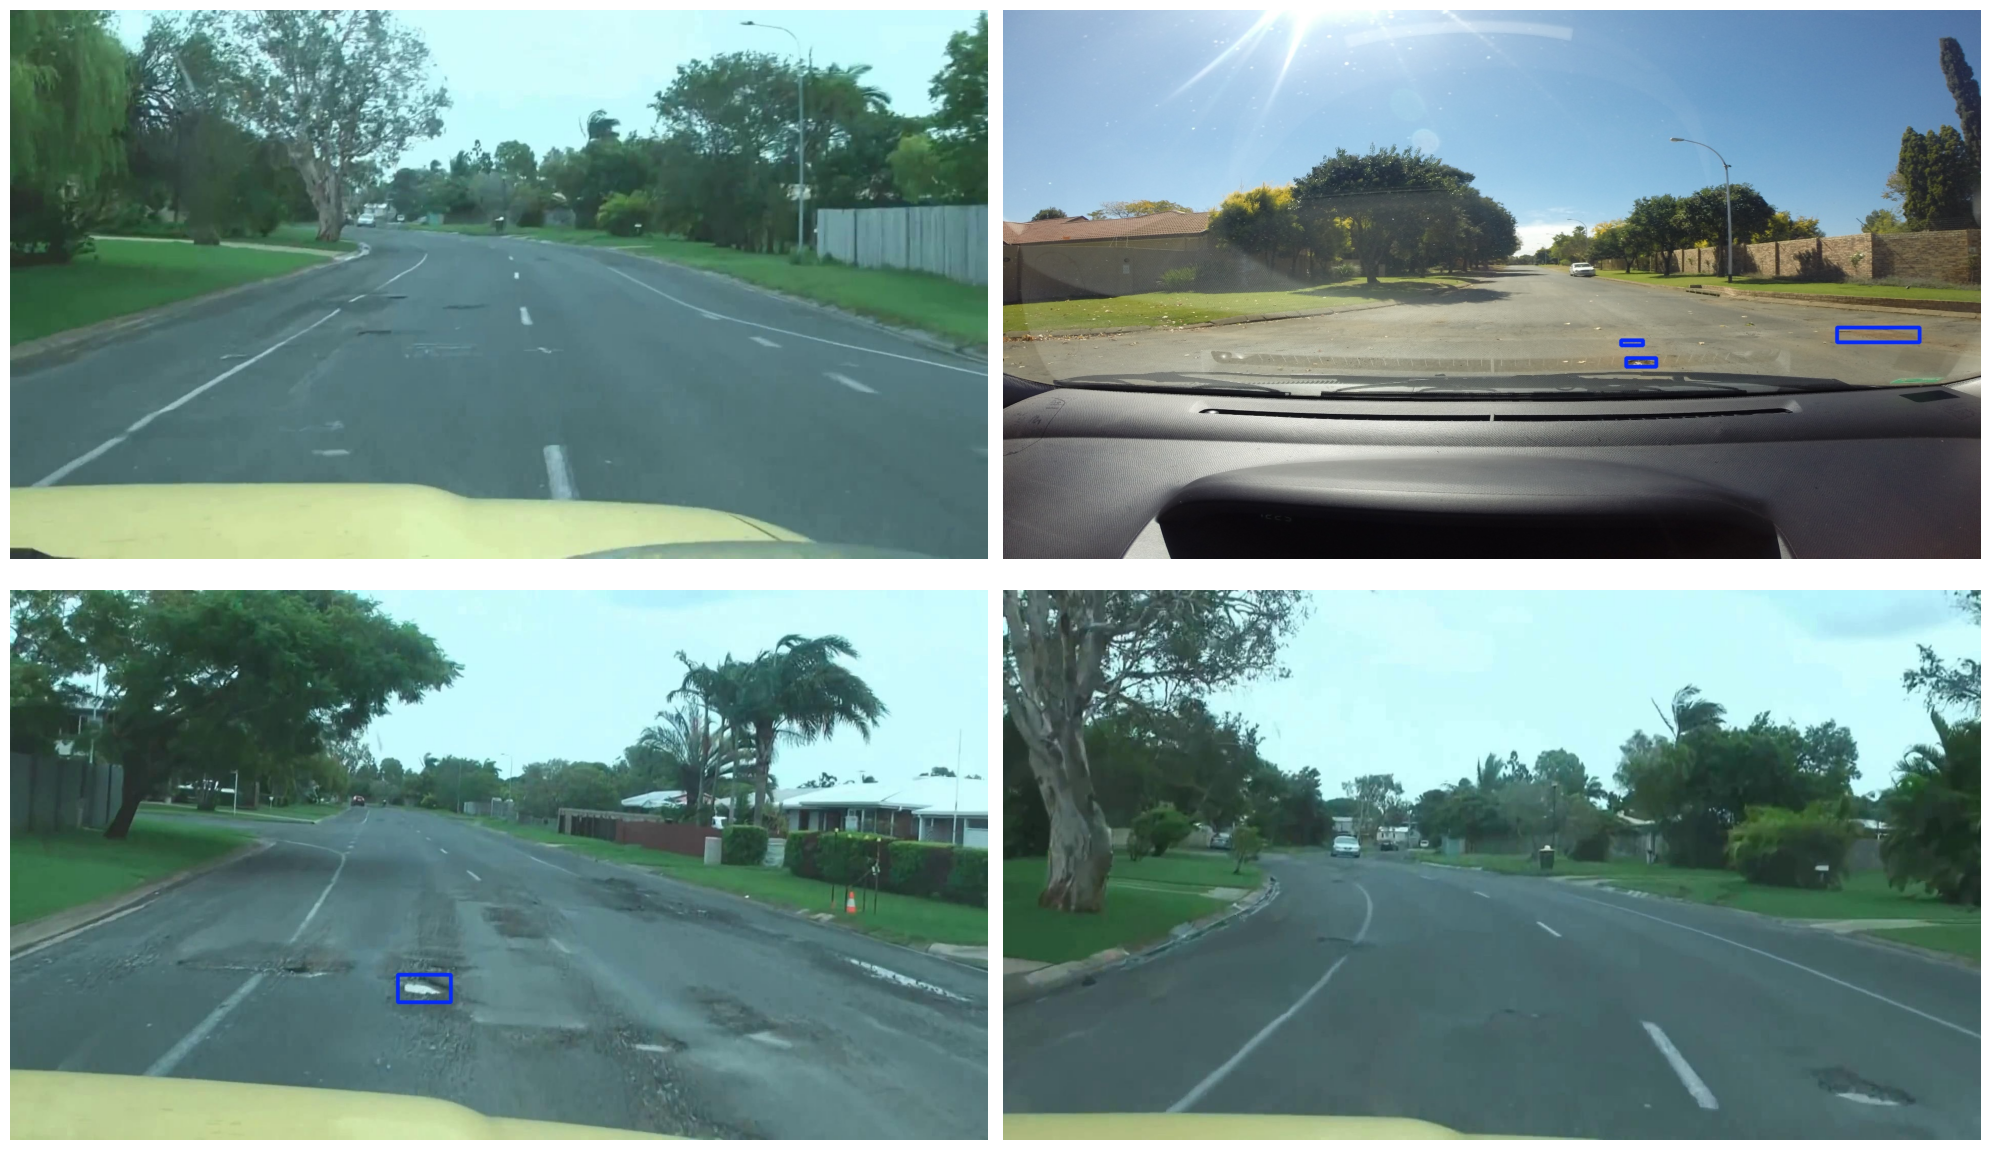

In [18]:
visualize('runs/detect/yolov8n_v8_50e_infer1280/')


0: 736x1280 (no detections), 45.2ms
Speed: 12.0ms preprocess, 45.2ms inference, 29.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 2 potholes, 12.3ms
Speed: 7.8ms preprocess, 12.3ms inference, 123.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 2 potholes, 12.3ms
Speed: 9.3ms preprocess, 12.3ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 3 potholes, 12.2ms
Speed: 7.9ms preprocess, 12.2ms inference, 1.6ms postprocess per image at shape (1, 3, 736, 1280)


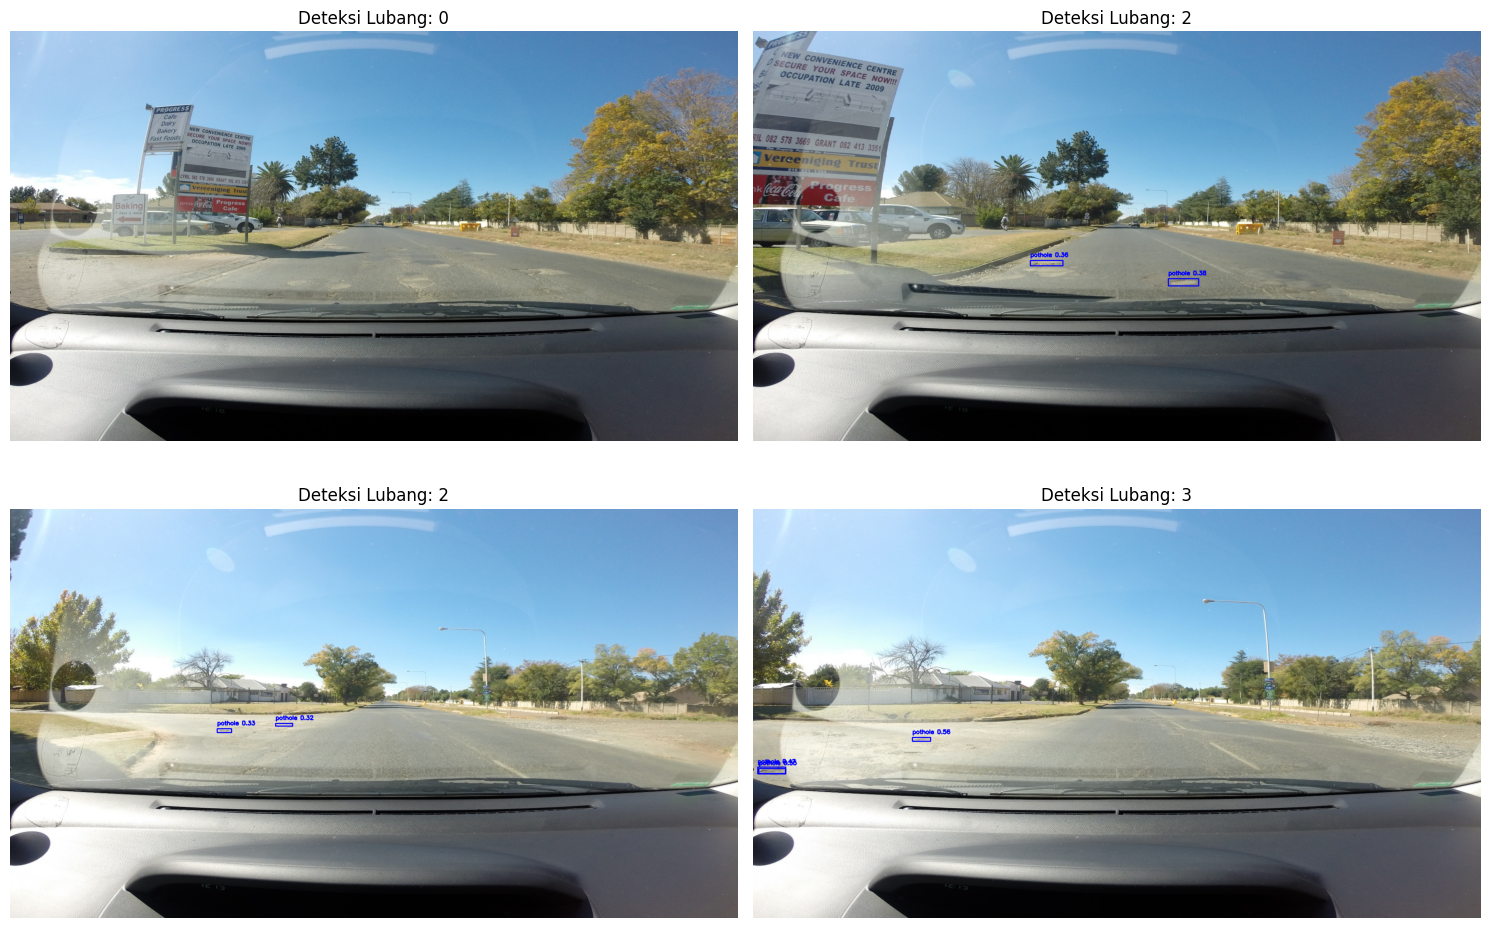

In [19]:
from ultralytics import YOLO
import matplotlib.pyplot as plt
import cv2
import glob
import os

# Load model
model_path = 'runs/detect/yolov8n_v8_50e/weights/best.pt'
model = YOLO(model_path)

# Ambil gambar dari folder validasi
image_dir = 'datasets/pothole_dataset_v8/valid/images'
image_paths = sorted(glob.glob(os.path.join(image_dir, '*.jpg')))

plt.figure(figsize=(15, 10))
for i in range(min(4, len(image_paths))):
    img_path = image_paths[i]
    image = cv2.imread(img_path)

    # Inference
    results = model(image)[0]

    # Gambar bounding box & hitung
    count = 0
    for box in results.boxes:
        if box.conf.item() >= 0.25:
            count += 1
            xyxy = box.xyxy.cpu().numpy().astype(int)[0]
            label = results.names[int(box.cls)]
            conf = box.conf.item()
            cv2.rectangle(image, (xyxy[0], xyxy[1]), (xyxy[2], xyxy[3]), (255, 0, 0), 2)
            cv2.putText(image, f"{label} {conf:.2f}", (xyxy[0], xyxy[1]-10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Konversi ke RGB untuk plt.imshow
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Tampilkan
    plt.subplot(2, 2, i+1)
    plt.imshow(img_rgb)
    plt.title(f'Deteksi Lubang: {count}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [1]:
# ============================
# MENGHITUNG JUMLAH LUABNG DARI DATA VIDEO
# ============================
from ultralytics import YOLO
import cv2
from norfair import Detection, Tracker
import numpy as np

# Fungsi bantu untuk ubah hasil YOLO ke format Norfair
def yolo_to_norfair_detections(boxes, threshold=0.25):
    detections = []
    for box in boxes:
        if box.conf.item() >= threshold:
            xyxy = box.xyxy.cpu().numpy().astype(int)[0]
            x_center = (xyxy[0] + xyxy[2]) / 2
            y_center = (xyxy[1] + xyxy[3]) / 2
            detections.append(Detection(points=np.array([[x_center, y_center]])))
    return detections

# Fungsi utama
def run_tracked_inference(video_path, model_path, conf_threshold=0.25):
    model = YOLO(model_path)
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("❌ Error: Video tidak bisa dibuka.")
        return

    frame_width  = int(cap.get(3))
    frame_height = int(cap.get(4))
    fps = cap.get(cv2.CAP_PROP_FPS)

    save_path = 'video_final_tracked.avi'
    out = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'XVID'), fps, (frame_width, frame_height))

    # Norfair Tracker
    tracker = Tracker(distance_function="euclidean", distance_threshold=30)
    unique_ids = set()  # Menyimpan ID objek unik

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        results = model(frame)[0]
        detections = yolo_to_norfair_detections(results.boxes, threshold=conf_threshold)
        tracked_objects = tracker.update(detections=detections)

        for obj in tracked_objects:
            obj_id = obj.id
            if obj_id not in unique_ids:
                unique_ids.add(obj_id)

            # Gambar bounding box kasar
            cx, cy = obj.estimate[0]
            x1, y1 = int(cx - 30), int(cy - 30)
            x2, y2 = int(cx + 30), int(cy + 30)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0,255,0), 2)
            cv2.putText(frame, f"ID: {obj.id}", (x1, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)

        # Tambahkan info total lubang unik
        cv2.putText(frame, f"Unique Holes Detected: {len(unique_ids)}", (10, 30),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

        out.write(frame)  # Simpan frame ke video output

    cap.release()
    out.release()
    print(f"\n✅ Video hasil tracking disimpan di: {save_path}")
    print(f"🔢 Total lubang unik terdeteksi sepanjang video: {len(unique_ids)}")

video_path = "/content/video tes YOLO.mp4"  # Ganti dengan path video kamu di Colab
model_path = "runs/detect/yolov8n_v8_50e/weights/best.pt"

run_tracked_inference(video_path, model_path)


0: 736x1280 1 pothole, 105.9ms
Speed: 11.7ms preprocess, 105.9ms inference, 237.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 (no detections), 26.7ms
Speed: 19.9ms preprocess, 26.7ms inference, 1.1ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 (no detections), 12.8ms
Speed: 7.9ms preprocess, 12.8ms inference, 1.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 (no detections), 13.2ms
Speed: 6.9ms preprocess, 13.2ms inference, 1.2ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 pothole, 12.3ms
Speed: 6.4ms preprocess, 12.3ms inference, 2.4ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 pothole, 12.3ms
Speed: 6.3ms preprocess, 12.3ms inference, 2.5ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 pothole, 12.3ms
Speed: 6.2ms preprocess, 12.3ms inference, 2.3ms postprocess per image at shape (1, 3, 736, 1280)

0: 736x1280 1 pothole, 12.3ms
Speed: 6.2ms preprocess, 12.3ms inference,